## Analyse the Extracted Samples

In [1]:
# import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pickle
import warnings
import tqdm
import pandas as pd
import librosa
from scipy import signal
from scipy.stats import zscore
from scipy.io import wavfile
from scipy.fft import fft,fftfreq
from scipy.fftpack import fft

warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.dpi"] = 100

CURR_DIR = os.getcwd()

In [2]:
# make necessary definitions

# directories definitions
MAIN_DIR = "."
DATA_DIR = os.path.join(MAIN_DIR,"dataset")
FIG_DIR = os.path.join(MAIN_DIR,"figures")
os.makedirs(FIG_DIR,exist_ok=True)
if os.path.basename(os.getcwd())!="Silent-Interface-for-IOT-Devices":
    os.chdir("..")

# hardware definitions
SAMPLING_RATE = 250
NUM_CHANNELS = 8

# dataset definitions
SPEAKER = ["RL","RN","SR","US"]
SESSION = ["session1","session2","session3"]
MODE = ["mentally","mouthed","audible"]
SENTENCES =["अबको समय सुनाउ","एउटा सङ्गित बजाउ","आजको मौसम बताउ","बत्तिको अवस्था बदल","पङ्खाको स्तिथी बदल"]
WORDS = ["समय","सङ्गित","मौसम","बत्ति","पङ्खा"]

SENTENCE_LABEL= np.array(SENTENCES)[[0,1,2,0,3,1,0,3,0,0,1,1,3,3,4,4,2,3,1,2,2,2,4,4,4]]
WORD_LABEL= np.array(WORDS)[[4,0,3,1,0,1,1,0,4,0,3,2,4,4,2,1,4,1,2,2,2,0,3,3,3]]

LABELS = {"word":WORD_LABEL,"sentence":SENTENCE_LABEL}


# a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=100):
    path = os.path.join(FIG_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

In [3]:
all_files = glob.glob(DATA_DIR+"/*/*/*/*/*.txt",recursive=True)
print(len(all_files))

159


In [4]:
def parser(files,FILTER=True):
    """
    parser function to extract utterances from .txt file and store them in a dictionary
    """
    
    dataset = {"data":[], "speaker":[], "mode":[], "utter_type":[], "labels":[], "session":[], "filename":[]}
    def get_data(file):
        session = file.split("/")[-4]
        mode = file.split("/")[-2]
        speaker = file.split("/")[-5]
        utter_type = file.split("/")[-3]
        filename = file.split("/")[-1]
        f = open(file, 'r')
        contents = map(lambda x : x.strip(), f.readlines())
        #the file starts with '%' and some instruction before data and removing these data 
        frames_original = list(filter(lambda x : x and x[0] != '%', contents))[1:]
        #the data row contains channels info digital trigger and accelerometer info separated by comma
        frames_original = list(map(lambda s : list(map( lambda ss: ss.strip(), s.split(','))), frames_original))
        # (8 channels) + digital triggers
        # the digital trigger is in a[16], used to indicate the utterance
        frames = list(map(lambda a: list(map(float, a[1:9])) + [float(a[16])] , frames_original))
        frames = np.array(frames)
        indices = []
        signal = []
        for index,f in enumerate(frames[:,-1]):
            if(bool(f) ^ bool(frames[(index+1) if ((index+1)<len(frames)) else index,-1]) ):
                indices.append(index)
                if len(indices)>1 and len(indices)%2==0:
                    signal.append(frames[indices[len(indices)-2]:indices[len(indices)-1],:-1])   
        
        # only take files with 25 labels         
        if (len(signal)!=25 and FILTER):
            return
        
        dataset["data"].extend(signal)
        dataset["speaker"].extend([speaker]*len(signal))
        dataset["mode"].extend([mode]*len(signal))
        dataset["session"].extend([session]*len(signal))
        dataset["utter_type"].extend([utter_type]*len(signal))
        dataset["labels"].extend(LABELS[utter_type])
        dataset["filename"].extend([filename]*len(signal))
        
    for file,i in zip(files,tqdm.tqdm(range(1,len(files)+1),desc="PARSING DATA")):
        get_data(file)
    
    return dataset

In [5]:
all_data = parser(all_files)

PARSING DATA:  99%|█████████▉| 158/159 [02:03<00:00,  1.28it/s]


In [6]:
print(type(all_data))
print(all_data.keys())
print(len(all_data["data"]))
# print(len(all_data["speaker"]))
# print(len(all_data["mode"]))
# print(len(all_data["utter_type"]))
# print(len(all_data["labels"]))
# print(len(all_data["session"]))
# print(len(all_data["filename"]))

<class 'dict'>
dict_keys(['data', 'speaker', 'mode', 'utter_type', 'labels', 'session', 'filename'])
3225


In [7]:
df = pd.DataFrame(all_data)

In [8]:
df.head(5)

,data,speaker,mode,utter_type,labels,session,filename
0,"[[-23755.56640625, 6967.79833984375, 1868.1140...",US,mentally,word,पङ्खा,session2,OpenBCI-RAW-2021-05-14_11-13-41.txt
1,"[[-23746.939453125, 7065.78857421875, 2068.944...",US,mentally,word,समय,session2,OpenBCI-RAW-2021-05-14_11-13-41.txt
2,"[[-23682.119140625, 7196.88134765625, 2202.943...",US,mentally,word,बत्ति,session2,OpenBCI-RAW-2021-05-14_11-13-41.txt
3,"[[-23777.673828125, 6779.52978515625, 1731.097...",US,mentally,word,सङ्गित,session2,OpenBCI-RAW-2021-05-14_11-13-41.txt
4,"[[-23601.005859375, 7044.93408203125, 2030.320...",US,mentally,word,समय,session2,OpenBCI-RAW-2021-05-14_11-13-41.txt


In [9]:
df.tail(5)

,data,speaker,mode,utter_type,labels,session,filename
3220,"[[-192.94024658203125, -10373.7568359375, -168...",RL,audible,sentence,आजको मौसम बताउ,session3,OpenBCI-RAW-2021-05-15_16-23-31.txt
3221,"[[-218.64476013183594, -10277.287109375, -1516...",RL,audible,sentence,आजको मौसम बताउ,session3,OpenBCI-RAW-2021-05-15_16-23-31.txt
3222,"[[-316.6347961425781, -10496.892578125, -1831....",RL,audible,sentence,पङ्खाको स्तिथी बदल,session3,OpenBCI-RAW-2021-05-15_16-23-31.txt
3223,"[[-439.14471435546875, -10457.419921875, -1464...",RL,audible,sentence,पङ्खाको स्तिथी बदल,session3,OpenBCI-RAW-2021-05-15_16-23-31.txt
3224,"[[-495.1805419921875, -10950.72265625, -1888.9...",RL,audible,sentence,पङ्खाको स्तिथी बदल,session3,OpenBCI-RAW-2021-05-15_16-23-31.txt


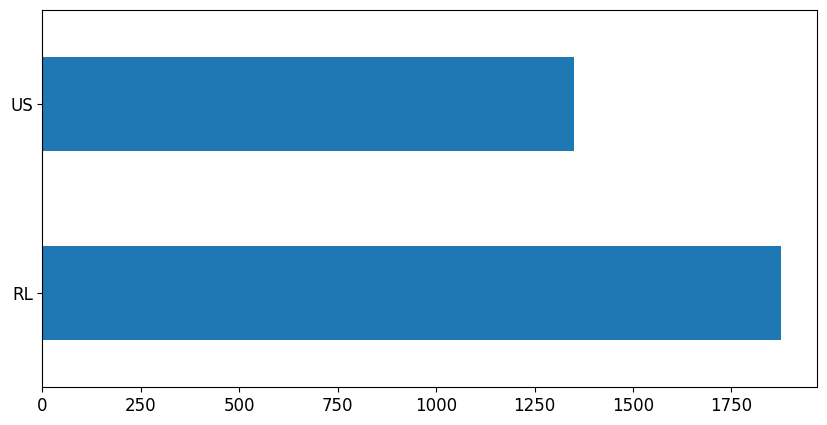

In [10]:
df["speaker"].value_counts().plot.barh()
plt.show()

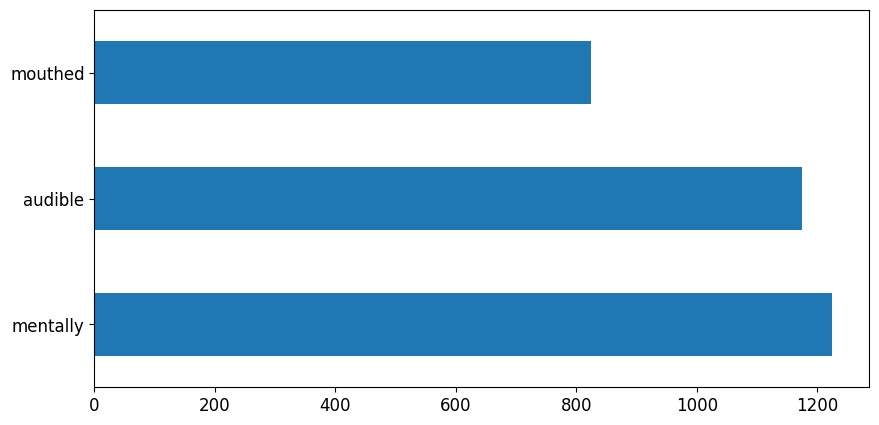

In [11]:
df["mode"].value_counts().plot.barh()
plt.show()

### ANALYZE LENGTH OF SAMPLES

In [12]:
all_words = df[df["utter_type"]=="word"]
all_sentences = df[df["utter_type"]=="sentence"]
all_word_length = [x.shape[0]/SAMPLING_RATE for x in all_words["data"]]
all_sent_length = [x.shape[0]/SAMPLING_RATE for x in all_sentences["data"]]

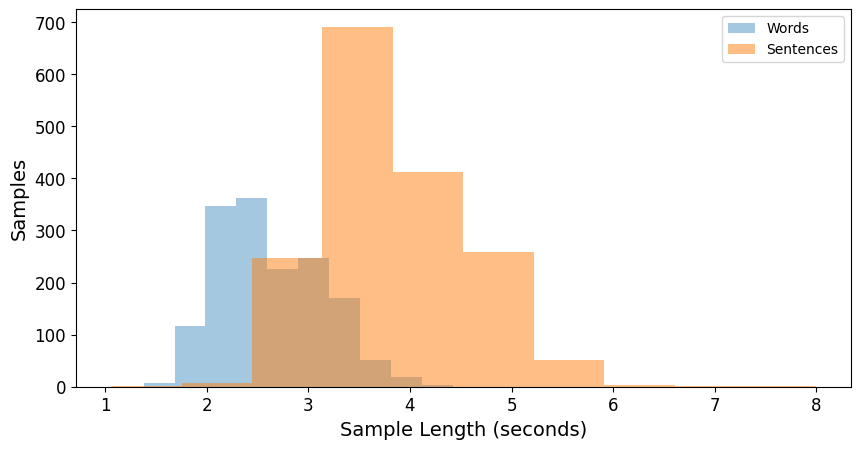

In [13]:
plt.hist(all_word_length,alpha=0.4)
plt.hist(all_sent_length,alpha=0.5)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
# save_fig("length distribution")
plt.legend(["Words","Sentences"])
plt.show()

In [14]:
print("Max length of words utterances in seconds: %.2fs" % np.max(all_word_length))
print("Min length of words utterances in seconds: %.2fs" % np.min(all_word_length))
print("Avg length of words utterances in seconds: %.2fs" % np.mean(all_word_length))
print("\n")
print("Max length of sentence utterances in seconds: %.2fs" % np.max(all_sent_length))
print("Min length of sentence utterances in seconds: %.2fs" % np.min(all_sent_length))
print("Avg length of sentence utterances in seconds: %.2fs" % np.mean(all_sent_length))

Max length of words utterances in seconds: 4.42s
Min length of words utterances in seconds: 1.38s
Avg length of words utterances in seconds: 2.63s


Max length of sentence utterances in seconds: 7.99s
Min length of sentence utterances in seconds: 1.06s
Avg length of sentence utterances in seconds: 3.84s


In [15]:
all_words_RL = df.query('utter_type=="word" and speaker=="RL"')
all_words_US = df.query('utter_type=="word" and speaker=="US"')

all_sent_RL = df.query('utter_type=="sentence" and speaker=="RL"')
all_sent_US = df.query('utter_type=="sentence" and speaker=="US"')


all_word_length_RL = [x.shape[0]/SAMPLING_RATE for x in all_words_RL["data"]]
all_sent_length_RL = [x.shape[0]/SAMPLING_RATE for x in all_sent_RL["data"]]

all_word_length_US = [x.shape[0]/SAMPLING_RATE for x in all_words_US["data"]]
all_sent_length_US = [x.shape[0]/SAMPLING_RATE for x in all_sent_US["data"]]


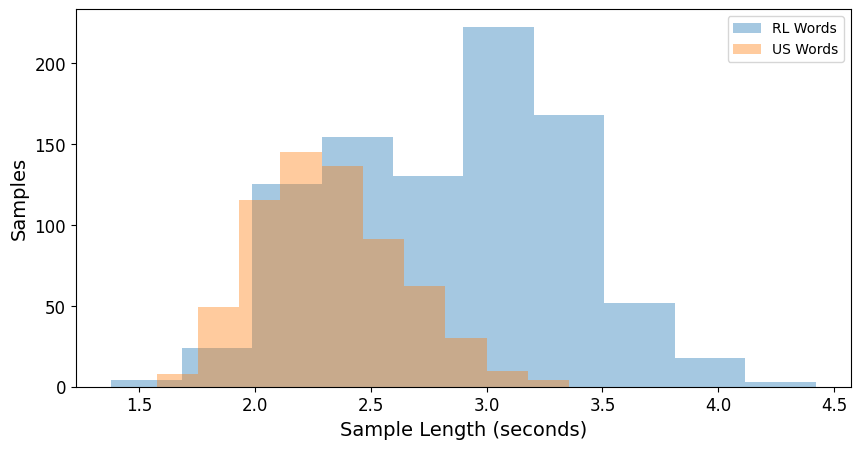

In [16]:
plt.hist(all_word_length_RL,alpha=0.4)
plt.hist(all_word_length_US,alpha=0.4)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
# save_fig("length distribution")
plt.legend(["RL Words","US Words"])
plt.show()

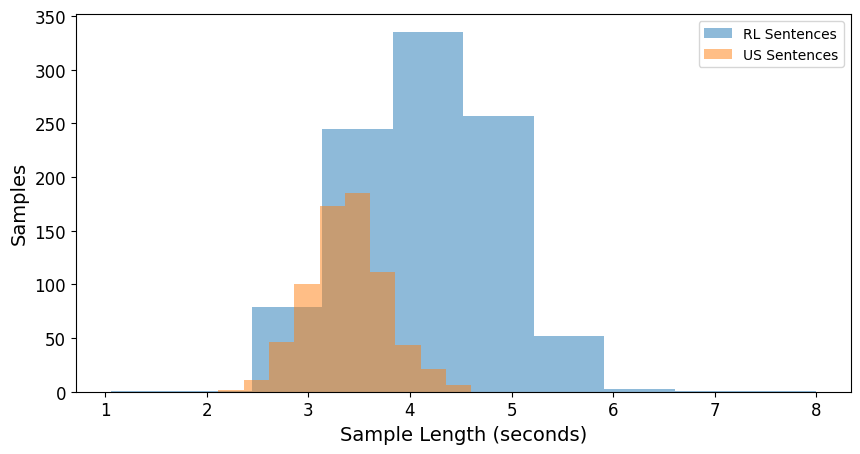

In [17]:
plt.hist(all_sent_length_RL,alpha=0.5)
plt.hist(all_sent_length_US,alpha=0.5)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
# save_fig("length distribution")
plt.legend(["RL Sentences","US Sentences"])
plt.show()

In [18]:
# SENTENCES =["अबको समय सुनाउ","एउटा सङ्गित बजाउ","आजको मौसम बताउ","बत्तिको अवस्था बदल","पङ्खाको स्तिथी बदल"]
# WORDS = ["समय","सङ्गित","मौसम","बत्ति","पङ्खा"]

all_words_RL = df.query('utter_type=="word" and speaker=="RL" and labels=="मौसम"')
all_words_US = df.query('utter_type=="word" and speaker=="US" and labels=="मौसम"')

all_sent_RL = df.query('utter_type=="sentence" and speaker=="RL" and labels=="आजको मौसम बताउ"')
all_sent_US = df.query('utter_type=="sentence" and speaker=="US" and labels=="आजको मौसम बताउ"')


all_word_length_RL = [x.shape[0]/SAMPLING_RATE for x in all_words_RL["data"]]
all_sent_length_RL = [x.shape[0]/SAMPLING_RATE for x in all_sent_RL["data"]]

all_word_length_US = [x.shape[0]/SAMPLING_RATE for x in all_words_US["data"]]
all_sent_length_US = [x.shape[0]/SAMPLING_RATE for x in all_sent_US["data"]]


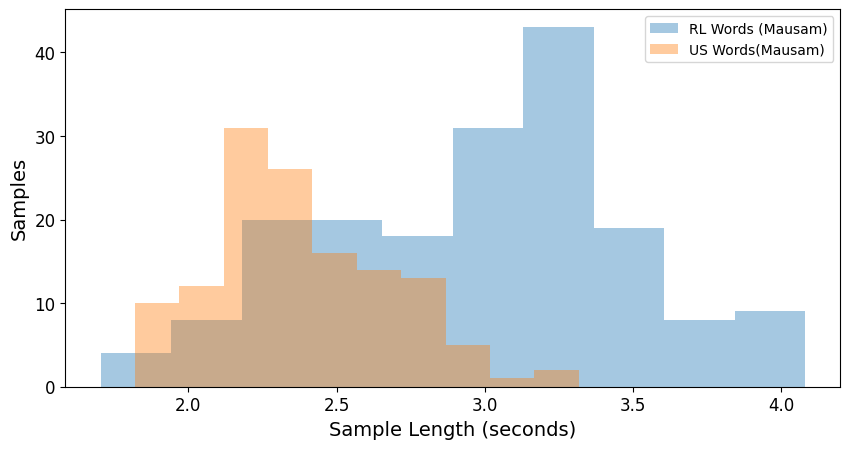

In [19]:
plt.hist(all_word_length_RL,alpha=0.4)
plt.hist(all_word_length_US,alpha=0.4)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
# save_fig("length distribution")
plt.legend(["RL Words (Mausam)","US Words(Mausam)"])
plt.show()

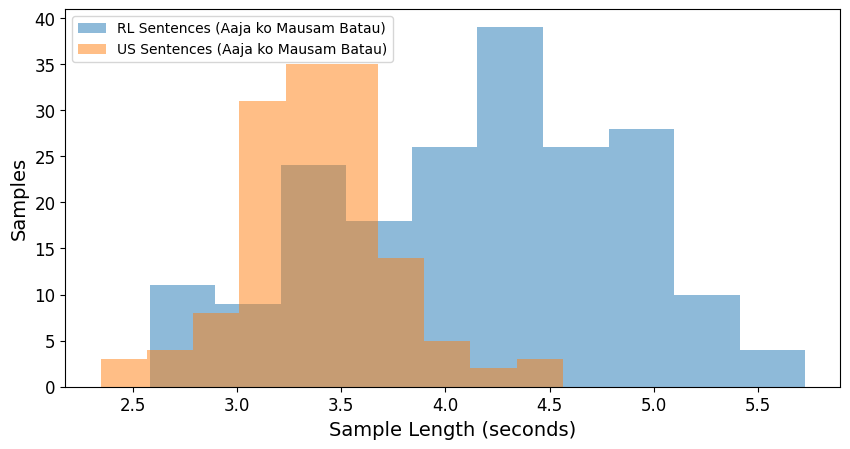

In [20]:
plt.hist(all_sent_length_RL,alpha=0.5)
plt.hist(all_sent_length_US,alpha=0.5)
plt.xlabel("Sample Length (seconds)")
plt.ylabel("Samples")
# save_fig("length distribution")
plt.legend(["RL Sentences (Aaja ko Mausam Batau)","US Sentences (Aaja ko Mausam Batau)"])
plt.show()

### SIGNAL ANALYSIS

In [21]:
xxx = 42
sample_RL_audible = df.query('utter_type=="sentence" and mode=="audible" and speaker=="RL"')["data"].iloc[xxx]
sample_RL_mouthed = df.query('utter_type=="sentence" and mode=="mouthed" and speaker=="RL"')["data"].iloc[xxx]
sample_RL_mentally = df.query('utter_type=="sentence" and mode=="mentally" and speaker=="RL"')["data"].iloc[xxx]

sample_US_audible = df.query('utter_type=="sentence" and mode=="audible" and speaker=="US"')["data"].iloc[xxx]
sample_US_mouthed = df.query('utter_type=="sentence" and mode=="mouthed" and speaker=="US"')["data"].iloc[xxx]
sample_US_mentally = df.query('utter_type=="sentence" and mode=="mentally" and speaker=="US"')["data"].iloc[xxx]


In [22]:

# sample = np.transpose(sample_RL_audible)
# sample = np.transpose(sample_RL_mouthed)
# sample = np.transpose(sample_RL_mentally)
sample = np.transpose(sample_US_audible)
# sample = np.transpose(sample_US_mouthed)
# sample = np.transpose(sample_US_mentally)

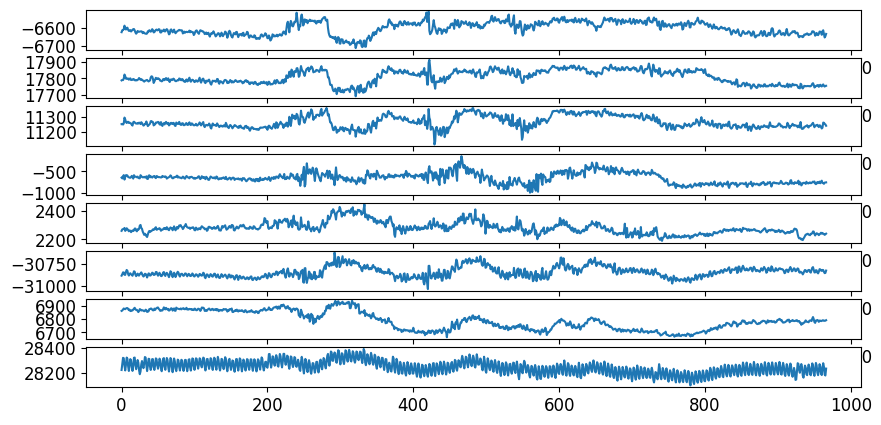

In [23]:
fig, axes = plt.subplots(nrows=8,ncols=1)
for i in range(8):
    axes[i].plot(sample[i])
#     axes[i].plot(sample2[i])
plt.show()

In [24]:
sample = np.transpose(sample)
print(sample.shape)

(967, 8)


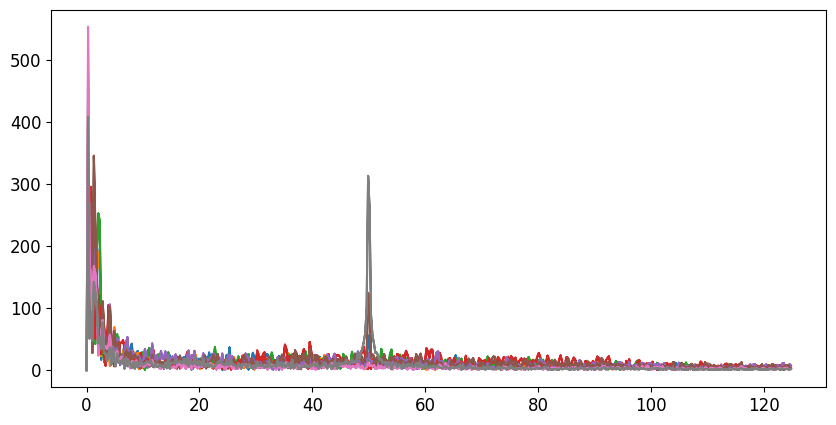

In [25]:
N = len(sample)

for i in range(8):
    y = fft(zscore(sample[:,i]))
    x = fftfreq(N,1/250)
    plt.plot(abs(x),abs(y))
# plt.plot(abs(X),abs(Y))
# plt.legend(["mentally","audible"])
plt.show()

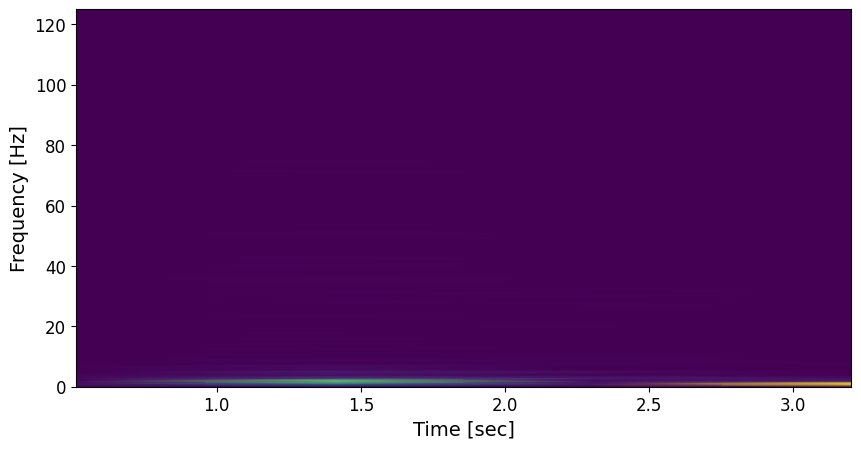

In [26]:
f, t, Sxx = signal.spectrogram(sample[:,1], SAMPLING_RATE)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### SIGNAL SMOOTHING

In [290]:
def smoother(X,Y=0,POINTS=8):
    """
    SMOOTHES THE INPUT SIGNAL AVERAGING OVER 8 DATA POINTS (ARNAV)
    """
    new_X = []
    for SIGNAL,index in zip(X,tqdm.tqdm(range(len(X)),desc="Smoothing Signal")):
        XX = [] 
        for channel in range(NUM_CHANNELS):
            XXX = []
            for i in range(len(SIGNAL[channel])):
                a = i
                b = i+POINTS
                if(b>len(SIGNAL[channel])): break
                XXX.append(int((np.sum(SIGNAL[channel][a:b]))/POINTS))
            XX.append(np.array(XXX))
        new_X.append(np.vstack(XX))
    return new_X,Y

### DIGITAL FILTERS

In [291]:
# filter definition
def digital_filter(SIGNAL,HPF,LPF,ORDER,RICKER=False):
    def butterworth(TYPE,CUTOFF,data,ORDER=1,SR=SAMPLING_RATE,OUTPUT='sos'):
        """
        IIR BUTTERWORTH FILTER 
        TYPE: "highpass","lowpass","bandpass"
        data: input signal
        CUTOFF: cut-off frequency of the filter
        """
        sos = signal.butter(ORDER,CUTOFF,TYPE,fs=SR,output=OUTPUT)
        return signal.sosfilt(sos,data)

    def notch(data,FREQUENCY=50,Q_FACTOR=30,SR=SAMPLING_RATE):
        """
        NOTCH FILTER
        data: input signal
        """
        b,a = signal.iirnotch(FREQUENCY,Q_FACTOR,SR)
        return signal.lfilter(b,a,data)
    
    def ricker(SIGNAL,sample_rate=250):
        """
        RICKER CONVOLUTION TO REMOVE HEARTBEAT ARTIFACTS
        """
        ricker_width = 35 * sample_rate // 250
        ricker_sigma = 4.0 * sample_rate / 250
        ricker = signal.ricker(ricker_width,ricker_sigma)
        # normalize ricker
        ricker = np.array(ricker, np.float32) / np.sum(np.abs(ricker))
        convolution = signal.convolve(SIGNAL,ricker,mode="same")
        return (SIGNAL-2*convolution)

    SIGNAL = butterworth("highpass",HPF,SIGNAL,ORDER=ORDER)
    SIGNAL = notch(SIGNAL)
    SIGNAL = butterworth("lowpass",LPF,SIGNAL,ORDER=ORDER)
    if(RICKER):
        SIGNAL = ricker(SIGNAL)
    return SIGNAL


# filter application
def apply_filter(X,Y=0,HPF=1.5,LPF=20,ORDER=2,RICKER=False):
    """
    HPF -> LPF -> NOTCH -> RICKER
    """
    new_X = []
    for SIGNAL,index in zip(X,tqdm.tqdm(range(len(X)),desc="Filtering Signal")):
        XX = []
        for channel in range(NUM_CHANNELS):
            XX.append(digital_filter(zscore(SIGNAL[channel]),HPF=HPF,LPF=LPF,ORDER=ORDER,RICKER=RICKER))
        new_X.append(np.vstack(XX))

    return new_X,Y

In [292]:
def signal_pipeline(X,Y=0):
    """
    SIGNAL SMOOTHING --> SIGNAL NORMALIZATION --> DIGITAL FILTERING
    """
    print("Performing Signal Processing")
    new_X,new_Y = smoother(X,Y)
    new_X,new_Y = apply_filter(new_X,new_Y,RICKER=False)
    return new_X,new_Y